In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from astropy.table import Table, vstack, Column
import os
import pdb
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import warnings
import resource
import timeit
start_time = timeit.default_timer()
# code you want to evaluate
resource.setrlimit(resource.RLIMIT_NOFILE, (10000,-1))

In [2]:
path = './../spectra/'
path2 = './../catalogs/'
bigFile = Table.read('bigfile.fits')
allnames = list(bigFile['SPEC1DNAME'])
vccfiles = []
vdgcfiles = []
vugcfiles = []
for filename in os.listdir(path):
    if ((filename.endswith(".fits")) & ("spec" in filename)):
       vdgcfiles.append(filename)
    elif ((filename.endswith(".gz")) & ("spec" in filename)):
       vugcfiles.append(filename)
    elif ((filename.endswith(".fits")) & ("VCC" in filename)):
        vccfiles.append(filename)
        
degc, denuc, icgc, m87gc, udggc= [],[],[],[],[]
path = './../spectra/'
for filename in os.listdir(path):
   if ((filename in allnames) | (filename + '.gz' in allnames)):
       if('.gz' in filename):
           objtype = str(bigFile[bigFile['SPEC1DNAME'] == filename]['Type'])
       else:
           objtype = str(bigFile[bigFile['SPEC1DNAME'] == filename + '.gz']['Type'])
       if ('DEGC' in objtype):
           degc.append(filename)
       elif ('DENU' in objtype):
           denuc.append(filename)
       elif ('ICL' in objtype):
           icgc.append(filename)
       elif ('Halo' in objtype):
           m87gc.append(filename)
       elif ('UDG' in objtype):
           udggc.append(filename)


In [3]:
vobsDEGC, vobsDENUC, vobsICGC, vobsM87, vobsUDGGC = [], [], [], [], [] 
def vobs(files):
    vobszero = np.zeros(len(files))
    for i in range(len(files)):
        try:
            vobszero[i] = (float(bigFile[bigFile['SPEC1DNAME'] == files[i]]['VOBS']))
        except:
            vobszero[i] = (float(bigFile[bigFile['SPEC1DNAME'] == files[i]+'.gz']['VOBS']))
    return vobszero
vobsDEGC = vobs(degc)
vobsDENUC = vobs(denuc)
vobsICGC = vobs(icgc)
vobsM87 = vobs(m87gc)
vobsUDGGC = vobs(udggc)

In [9]:
warnings.simplefilter("ignore", RuntimeWarning)
def spec_interp(wv,fx,nwwv,*args):
    #Required arguments:
    #   - wv: old wavelength array
    #   - fx: flux to be rebinned, 'SPEC'
    #   - nwwv: new wavelen gth array, interval
    #
    #Optional argument: variance
    npix = len(wv)
    if len(args) == 0:
        var = np.ones(npix)
        nwvarFlag = False
    else:
        var = args[0]
        nwvarFlag = True
    nwpix = len(nwwv)
    #Calculate wavelength endpoints for each pixel
    wvl = (wv + np.roll(wv,1))/2.
    wvh = (wv + np.roll(wv,-1))/2.
    wvl[0] = wv[0] - (wv[1] - wv[0])/2.
    wvh[npix-1] = wv[npix-1] + (wv[npix-1]-wv[npix-2])/2.
    #Calculate endpoints of the final array
    bwv = np.zeros(nwpix+1)
    bwv[0:nwpix] = (nwwv+np.roll(nwwv,1))/2.
    bwv[0] = nwwv[0] - (nwwv[1] - nwwv[0])/2.
    bwv[nwpix] = nwwv[nwpix-1]+(nwwv[nwpix-1] - nwwv[nwpix - 1])/2.
    #Create tmp arrays for final array
    nwfx = np.zeros(nwpix)
    nwvar = np.zeros(nwpix)
    nwunitfx = np.zeros(nwpix)
    #Loop through the arrays
    for q in range(npix):
        #No overlap
        if (wvh[q] <= bwv[0]) | (wvl[q] >= bwv[nwpix]):
            continue
        #Find pixel that bw is within
        if wvl[q] <= bwv[0]:
            i1 = [0]
        else:
            i1 = np.argwhere((wvl[q] <= np.roll(bwv,-1)) & (wvl[q] > bwv))[0]
        if wvh[q] > bwv[nwpix]:
            i2 = [nwpix-1]
        else:
            i2 = np.argwhere((wvh[q] <= np.roll(bwv,-1)) & (wvh[q] > bwv))[0]
        j1 = i1[0]
        j2 = i2[0]
        #Now Sum up
        for kk in range(j1,j2+1):
            #Rejected pixesl do not get added in
            if var[q] > 0.:
                frac = ( np.min([wvh[q],bwv[kk+1]]) - np.max([wvl[q],bwv[kk]]) ) / (wvh[q]-wvl[q])
                nwfx[kk] = nwfx[kk]+frac*fx[q]
                nwunitfx[kk] = nwunitfx[kk]+frac*1.0
                #Variance
                if nwvarFlag:
                    if (var[q] <= 0.) | (nwvar[kk] == -1):
                       nwvar[kk] = -1
                    else:
                       nwvar[kk] = nwvar[kk]+frac*var[q]
    if nwvarFlag:
        fxOut = nwfx/nwunitfx
        varOut = nwvar*nwunitfx
        
        return fxOut,varOut
    else:
        fxOut = nwfx/nwunitfx
        return fxOut


def rebinspec(*args,**kwargs):
    #Required arguments:
    #   - wv: old wavelength array
    #   - fx: flux to be rebinned
    #   - nwwv: new wavelength array
    #
    #Optional arguments:
    #   - var = var, input and output variance
    #   - ivar = ivar, input and output ivar

    if len(args) != 3:
        print('Proper syntax is: out = rebinspec(wv, fx, nwwv, **kwargs)')
        return np.nan

    else:
        wv, fx, nwwv = args

        var = kwargs.get('var',None)
        ivar = kwargs.get('ivar',None)

        if (var is not None) & (ivar is None):
            nwfx,nwvar = spec_interp(wv,fx,nwwv,var)

            return nwfx, nwvar
        elif (var is None) & (ivar is not None):
            var = 1./ivar
            nwfx,nwvar_1 = spec_interp(wv,fx,nwwv,var)
            nwvar_1[nwvar_1 == 0.0] = -10.0
            nwivar = 1.0/nwvar_1
            nwivar[nwivar < 0.0] = 0.0
            
            return nwfx, nwivar
        else:
            nwfx = spec_interp(wv,fx,nwwv)

            return nwfx

In [10]:
def plotting (fileName, title, vel, colors):
    correct = np.arange(4000,8750.9,0.9)
    allFluxes = []
    allIvar = []
    allWaves = []
    i = 0
    for f in fileName: 
        file = fits.open(path + f)
        try:                                  #check for Bxspf blue or red, if not I resort to Horne
            tempB = file['Bxspf-' + 'B']
            tempR = file['Bxspf-' + 'R']
        except:
            tempB = file['Horne-' + 'B']
            tempR = file['Horne-' + 'R']
        
        allWaves.append(np.append(((tempB.data['LAMBDA'])/(1 + ((vel[i]/300000)))), ((tempR.data['LAMBDA'])/(1 + ((vel[i]/300000))))))
        allFluxes.append(np.append(tempB.data['SPEC'], tempR.data['SPEC']))
        allIvar.append(np.append(tempB.data['IVAR'], tempR.data['IVAR']))              
        i = i + 1
        file.close()
    fileFlux = np.zeros((len(allWaves), len(correct)))
    fileVar = np.zeros((len(allWaves), len(correct)))
    for i in range (0, len(allWaves)):
        newFlux, newVar = np.nan_to_num(rebinspec(allWaves[i], allFluxes[i], correct, ivar = allIvar[i]))
        '''plt.plot(correct, newFlux, color = colors)
        plt.xlabel('Wavelength')
        plt.ylabel('Flux')
        plt.title(title)
        plt.show()'''
        fileFlux[i][:] = newFlux
        fileVar[i][:] = newVar
        
    
    return fileFlux, fileVar

In [11]:
fluxDEGC, varDEGC = plotting(degc, 'DEGC Spectra', vobsDEGC, 'mediumspringgreen')
fluxDENUC, varDENUC = plotting(denuc, 'NUC Spectra', vobsDENUC, 'mediumspringgreen')
fluxICGC, varICGC = plotting(icgc, 'ICGC Spectra', vobsICGC, 'mediumspringgreen')
fluxM87, varM87 = plotting(m87gc, 'Halo Spectra', vobsM87, 'mediumspringgreen')
fluxUDGGC, varUDGGC = plotting(udggc, 'UDGC Spectra', vobsUDGGC, 'mediumspringgreen')

In [12]:
def sigmaclipping(flux):
    correct = np.arange(4000,8750.9,0.9)
    ones = np.ones(np.shape(flux))
    means = np.mean(flux, axis = 0)
    stds = np.std(flux, axis = 0)
    ones[np.abs(flux - means) > 3 * stds] = 0
    a = ones * flux
    return ones

In [95]:
#region 6500 - 6600
# divide everything in that region of array a by that median
def normalize (flux):
    start = 2777
    end = 2889
    region = []
    np.array(region)
    medians = []
    increment = 0
    for j in range (0, len(flux)):
        for i in range (start, end):
            region = []
            region.append(flux[j][i])
            #fix this
        medians.append(np.median(region))
    for i in range (0, len(medians)):
            flux[i] = (flux[i] / medians[i])
    return flux




In [96]:
fluxDEGCnorm = normalize(fluxDEGC)
fluxDENUCnorm = normalize(fluxDENUC)
fluxICGCnorm = normalize(fluxICGC)
fluxM87norm = normalize(fluxM87)
fluxUDGGCnorm = normalize(fluxUDGGC)
#fluxVDGC = normalize(flux1)
#fluxVCC = normalize(flux2)

In [99]:
fluxDEGCnorm

array([[0.        , 0.        , 0.        , ..., 1.87150774, 1.49482998,
        1.19071838],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [35]:
def coadd(spectra, ivar, sigma):    
    spectra = np.nan_to_num(spectra)
    ivar = np.nan_to_num(ivar)

    clip = sigmaclipping(spectra)
    coadd_spectra = np.nan_to_num(np.sum(spectra * ivar * clip, axis = 0) / np.sum(ivar * clip, axis = 0))
    coadd_ivar = np.nan_to_num(np.sum(ivar * clip, axis = 0))
    coadd_err = np.nan_to_num(1 / np.sqrt(np.sum(ivar * clip, axis = 0)))

    return coadd_spectra, coadd_ivar, coadd_err

In [60]:
coaddSpecDEGC, coaddIvarDEGC, coaddErrDEGC = coadd(fluxDEGCnorm, varDEGC, 3)
coaddSpecDENUC, coaddIvarDENUC, coaddErrDENUC = coadd(fluxDENUCnorm, varDENUC, 3)
coaddSpecICGC, coaddIvarICGC, coaddErrICGC = coadd(np.nan_to_num(fluxICGCnorm), varICGC, 3)
coaddSpecM87, coaddIvarM87, coaddErrM87 = coadd(fluxM87norm, varM87, 3)
coaddSpecUDGGC, coaddIvarUDGGC, coaddErrUDGGC = coadd(fluxUDGGCnorm, varUDGGC, 3)

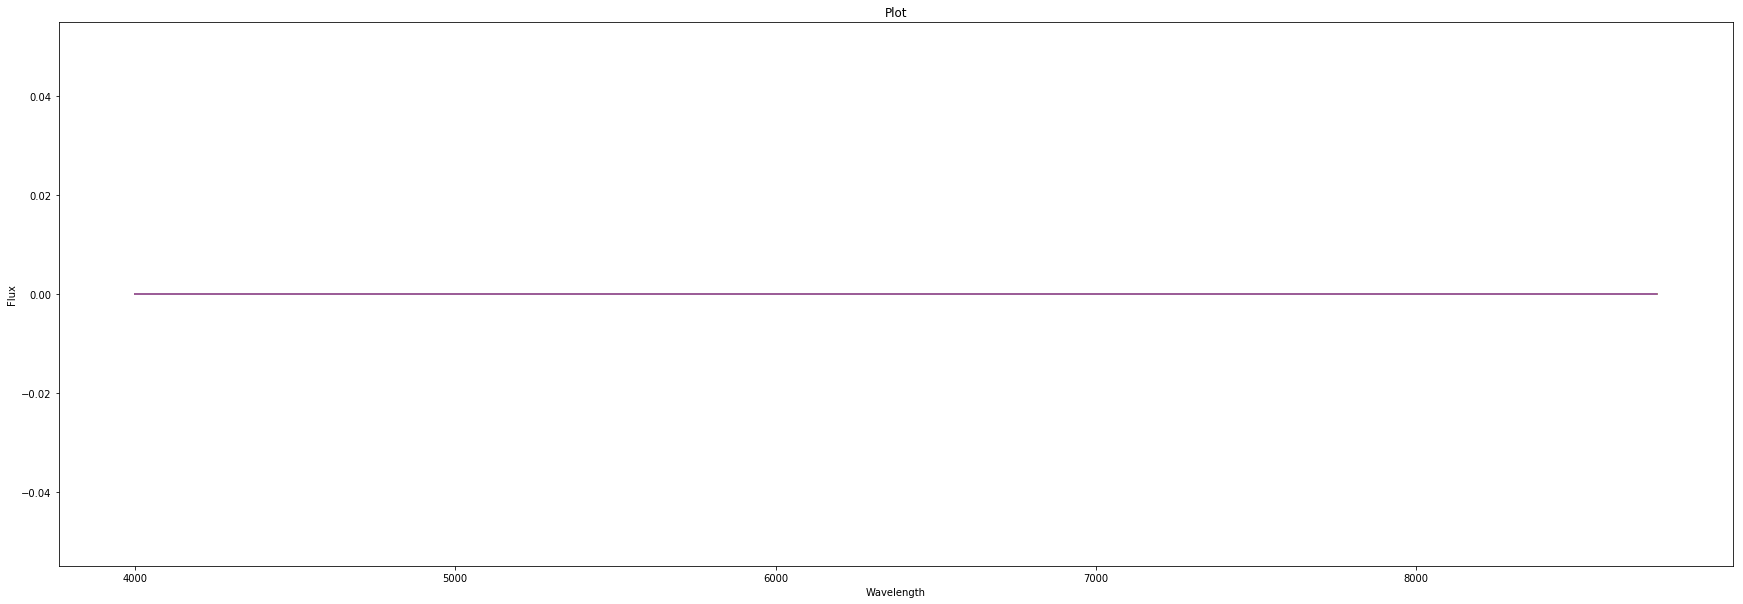

In [62]:
correct = np.arange(4000,8750.9,0.9)
plt.figure(figsize = (30,10))
plt.plot(correct, coaddSpecDEGC)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Plot')
plt.plot(correct, coaddSpecDENUC)
plt.plot(correct, coaddSpecUDGGC)
plt.plot(correct, coaddSpecICGC)
plt.plot(correct, coaddSpecM87)



In [19]:
test = sigmaclipping(fluxM87norm)

In [20]:
np.unique(test)

array([1.])